In [1]:
import pandas as pd
import numpy as np 
import sklearn as sk 
from hmmlearn import hmm
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.ndimage.interpolation import shift
from datetime import date, timedelta, datetime
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy.stats

### Signal Generation Functions

In [524]:
def generate_signal_rolling(start, end, X, states, window, delay, seed):
    np.random.seed(seed)
    signal = []
    count = 0
    
    X = X.reshape(-1, 1)
    
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    model.fit(X[start-window:start])
    predictions = model.predict(X[start-window:start])
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    for i in range(1, end-start):
        model.fit(X[start-window+i:start+i])
        predictions = model.predict(X[start-window+i:start+i])
        pred = predictions[-1]
        
        if pred == prev_pred:
            count = count + 1 
            
        elif pred != prev_pred:
            count = 1
            
        if count >= delay:
            signal.append(pred)
            
        elif count < delay:
            signal.append(signal[-1])
            
        prev_pred = pred
        
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        
    else: 
        signal = np.array(signal)
        
        
    return signal

def generate_signal_expanding(start, end, X, states, threshold, seed):
    np.random.seed(seed)
    signal = []
    count = 0
    
    X = X.reshape(-1, 1)
    
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    model.fit(X[:start])
    predictions = model.predict(X[:start])
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    for i in range(1, end-start):
        model.fit(X[:start+i])
        predictions = model.predict(X[:start+i])
        pred = predictions[-1]
        
        if pred == prev_pred:
            count = count + 1 
            
        elif pred != prev_pred:
            count = 1
            
        if count >= threshold:
            signal.append(pred)
            
        elif count < threshold:
            signal.append(signal[-1])
            
        prev_pred = pred
        
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        
    else: 
        signal = np.array(signal)
        
        
    return signal

### Cash Back-test Function

In [4]:
def backtest_signal(price, signal):
    w = np.zeros(np.shape(price))
    cash = np.zeros(np.shape(price))
    cash[0] = 10000

    for i in range(0, len(price)):

        if i == len(price)-1:
            break

        if signal[i] == 1: 
            w[i+1] = cash[i]/price[i]  + w[i]
            cash[i+1] = 0

        elif signal[i] == 0:
            cash[i+1] = w[i]*price[i] + cash[i]
            w[i+1] = 0
            
    strat = [a*b for a,b in zip(w[:-1], price)] + cash[:-1]
    
    return strat

### Performance Ratios Functions

In [683]:
def log_returns(strat):
    returns = np.log(shift(strat, -1)/strat)
    returns = np.delete(returns, -1)
    return returns

def sharpe(returns):
    sharpe_ratio = np.mean(returns)/np.std(returns)
    return np.round(sharpe_ratio * np.sqrt(252), 3)

def sortino(returns):
    downside_returns = [ret for ret in returns if ret < 0]
    std = np.std(downside_returns)
    sortino = np.mean(returns)/std
    return np.round(sortino * np.sqrt(252), 3)

def max_dd(data):
    p = np.argmax(np.maximum.accumulate(data) - data)
    q = np.argmax(data[:p])
    max_drawdown = (data[p]-data[q])/data[q]
    return np.round(abs(max_drawdown), 3)

def calmar(returns, strat):
    drawdown = max_dd(strat)
    calmar = np.sqrt(252) * np.mean(returns)/drawdown
    return np.round(calmar, 3) 

def absolute_return(price):
    abs_ret = (price[-1] - price[0])/price[0]
    annual_abs_ret = abs_ret/(len(price)/252)
    return annual_abs_ret

def ann_vol(price):
    # takes input price as numpy array
    vol = np.std(log_returns(price))
    annual_vol = vol * np.sqrt(252)
    return annual_vol
    
def print_ann_ret(strat, price):
    print("Strategy Annualised Return:", round(absolute_return(strat),3), sep='\n')
    print("Asset Annualised Return:", round(absolute_return(price.values),3), sep='\n')
    
    print("Strategy Annualised Vol:", round(ann_vol(strat),3), sep='\n')
    print("Asset Annualised Vol:", round(ann_vol(price.values),3), sep='\n')

def print_ratios(strat, price):
    print("Strategy:\nSharpe | Sortino | Calmar Ratios")
    print(
    sharpe(log_returns(strat)),
    sortino(log_returns(strat)),
    calmar(log_returns(strat), strat))
    print("Asset:\nSharpe | Sortino | Calmar Ratios")
    print(
    sharpe(log_returns(price.values)),
    sortino(log_returns(price.values)),
    calmar(log_returns(price.values), price.values))
    print("\n")
    
def plot_highlighted_graph(price, threshold, signal, string):
    values, ids = dc(price, threshold)
    idx = price.index
    d = []

    for i in range(1, len(idx)-1):
        if signal[i] == signal[i+1]:
            pass
        else:
            d.append(idx[i])

    d.append(idx[-1])

    plt.figure(figsize=(12,4))
    plt.title("Long (green) and Short (red) Regions of Price Output by HMM Model: Rolling Window", fontsize=18)
    plt.ylabel("Price", fontsize=18)
    plt.xlabel("Date", fontsize=18)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.plot(idx, price)
    plt.xticks(rotation=45)
    plt.scatter(idx[ids], values, s=200, c='r')

    if signal[0] == 1:
        plt.axvspan(idx[0], d[0], facecolor='g', alpha=0.5)  
        for i in range(0, len(d)-1, 2):
            plt.axvspan(d[i], d[i+1], facecolor='r', alpha=0.5)
        for i in range(1, len(d)-1, 2):
            plt.axvspan(d[i], d[i+1], facecolor='g', alpha=0.5)
    plt.tight_layout()
    #plt.grid()
    plt.savefig(string)
    plt.show() 

### DC Points Functions

In [6]:
def dc(price, threshold):

    curr_min = price[0]
    curr_min_id = 0
    curr_max = price[0]
    curr_max_id = 0
    min_bool = False
    max_bool = False

    values = []
    ids = []

    for i in range(1, len(price)):


        if price[i] > curr_max:
            curr_max = price[i]
            curr_max_id = i


        elif price[i] < curr_min:
            curr_min = price[i]
            curr_min_id = i


        if abs((price[i] - curr_min)/curr_min) >= threshold and min_bool == False:
            # save values and now look for OS point
            values.append(curr_min)
            ids.append(curr_min_id)

            values.append(price[i])
            ids.append(i)

            # reset min and max points
            curr_min = price[i]
            curr_min_id = i
            curr_max = price[i]
            curr_max_id = i
            min_bool = True
            max_bool = False

        elif abs((price[i] - curr_max)/curr_max) >= threshold and max_bool == False:
            # save values and now look for OS point
            values.append(curr_max)
            ids.append(curr_max_id)
            values.append(price[i])
            ids.append(i)

            # reset min and max points
            curr_min = price[i]
            curr_min_id = i
            curr_max = price[i]
            curr_max_id = i
            max_bool = True
            min_bool = False


    if min_bool == True:
        values.append(curr_max)
        ids.append(curr_max_id)
        
    elif max_bool == True:
        values.append(curr_min)
        ids.append(curr_min_id)
    

    return values, ids

## Training with multiple input features

- Make this a function such that "n" input sequences are fed into the model
- lengths/parameters are automatically calculated in-house in the model
- all input sequences will be the same length
- the model is trained over a "train" set of indices 
- the model is then predicted over a "test" set of indices with the output signal being generated
- Main aim: make sure the function is created in such a way that multiple input features can be fed into the model in some format 

Input to the function will be a PD dataframe containing the input features as columns!

In [705]:
def ret_data(tikka):
    ticker = yf.Ticker(tikka)
    data = ticker.history(period="15y")
    data["Returns"] = data["Close"].pct_change().dropna()
    data = data.dropna()
    data["Vol"] = data["Returns"].rolling(5).std()
    data = data.dropna()
    
    return data

def create_input_df(ticks):
    l = [ret_data(ticks[i]) for i in range(len(ticks))]

    r = []
    d = []

    # get max date (starting)
    for i in range(len(l)):
        d.append(l[i].index[0])

    # saving index
    idx = l[i].loc[d[np.argmax(d)]:].index
    
    # index values at most recent available date for all assets
    l2 = []
    for i in range(len(l)):
        l2.append(l[i].loc[d[np.argmax(d)]:])

    # make list
    for i in range(len(l)):
        r.append(l2[i]["Returns"].values)
    r.append(idx)    
    data_in = pd.DataFrame(r).T
    data_in.columns = ticks + ["Date"]
    data_in = data_in.set_index('Date')
    
    return data_in

def multi_train(data, split, window, delay, seed):
    # initialising seed and counter
    np.random.seed(seed)
    count = 0
    
    # obtaining splits of data
    split_val = int(split*len(data))
    train = data[:split_val]
    test = data[split_val:]

    # create the input numpy array from the pd df
    data_list = [train.iloc[:, i].values for i in range(len(train.columns))]
    X_train = np.concatenate(data_list)
    X_train = X_train.reshape(-1,1)
    lengths = [len(train.iloc[:, i].values) for i in range(len(train.columns))]
    
    # create input numpy array for the entire dataset 
    data_list = [data.iloc[:, i].values for i in range(len(data.columns))]
    X_test = np.concatenate(data_list)
    X_test = X_test.reshape(-1,1)
    #lengths_test = [len(data.iloc[:, i].values) for i in range(len(data.columns))]

    # initialise the model
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")

    # fit the model
    model = model.fit(X_train, lengths)

    # predict with the model
    signal = []
    predictions = model.predict(X_train[split_val-window:split_val])
    signal.append(predictions[-1])
    prev_pred = predictions[-1]

    for i in range(1, len(test)):
        predictions = model.predict(X_test[split_val-window+i:split_val+i])
        pred = predictions[-1]

        if pred == prev_pred:
            count = count + 1 

        elif pred != prev_pred:
            count = 1

        if count >= delay:
            signal.append(pred)

        elif count < delay:
            signal.append(signal[-1])

        prev_pred = pred

    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)

    else: 
        signal = np.array(signal)

    return signal, test.index[0]

def validate(tikka, s, start_idx):
    trial_price = ret_data(tikka)["Open"].loc[start_idx:][1:]
    
    strat = backtest_signal(trial_price, s)
    
    print_ratios(strat, trial_price)

    print_ann_ret(strat, trial_price)
    
    return

### Splitting up the train and test sections of the multi asset methods

In [867]:
df_re[:0]
[df_re.iloc[:, i].values for i in range(len(df_re.columns))]

[array(['AMT', 'ARE', 'AVB', 'BXP', 'CBRE', 'CCI', 'DLR', 'DRE', 'EQIX',
        'EQR', 'ESS', 'EXR', 'FRT', 'HST', 'IRM', 'KIM', 'MAA', 'O',
        'PEAK', 'PLD', 'PSA', 'REG', 'SBAC', 'SPG', 'UDR', 'VNO', 'VTR',
        'WELL', 'WY',
        'Downloaded from Barchart.com as of 08-26-2021 04:04am CDT'],
       dtype=object),
 array(['American Tower Corp', 'Alexandria Real Estate Equities',
        'Avalonbay Communities', 'Boston Properties', 'CBRE Group Inc',
        'Crown Castle International Corp', 'Digital Realty Trust',
        'Duke Realty Corp', 'Equinix Inc', 'Equity Residential',
        'Essex Property Trust', 'Extra Space Storage Inc',
        'Federal Realty Investment Trust', 'Host Marriott Financial Trust',
        'Iron Mountain Inc', 'Kimco Realty Corp',
        'Mid-America Apartment Communities', 'Realty Income Corp',
        'Healthpeak Properties Inc', 'Prologis Inc', 'Public Storage',
        'Regency Centers Corp', 'SBA Communications',
        'Simon Property 

In [890]:
def multi_train_com(data, split, window, seed):
    # initialising seed and counter
    np.random.seed(seed)
    count = 0
    
    # obtaining splits of data
    split_val = int(split*len(data))
    train = data[:split_val]
    test = data[split_val:]
    print(len(train), len(test))

    # create the input numpy array from the pd df
    data_list = [train.iloc[:, i].values for i in range(len(train.columns))]
    X_train = np.concatenate(data_list)
    X_train = X_train.reshape(-1,1)
    lengths = [len(train.iloc[:, i].values) for i in range(len(train.columns))]
    
    # create input numpy array for the entire dataset 
    data_list = [data.iloc[:, i].values for i in range(len(data.columns))]
    X_test = np.concatenate(data_list)
    X_test = X_test.reshape(-1,1)
    #lengths_test = [len(data.iloc[:, i].values) for i in range(len(data.columns))]

    # initialise the model
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")

    # fit the model
    model = model.fit(X_train, lengths)
    
    return model, test.index[0], split_val


def multi_test_com(model, start_idx, stock_to_validate, window, delay, seed):

    np.random.seed(seed)
    
    val_stock = ret_data(stock_to_validate)["Close"]
    start = val_stock.index.get_loc(start_idx)
    X = log_returns(val_stock.values)
    X = X.reshape(-1, 1)

    # predict with the model
    signal = []
    predictions = model.predict(X[0:start])
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    count = 0

    for i in range(1, len(X)-start):

        predictions = model.predict(X[i:start+i])
        pred = predictions[-1]

        if pred == prev_pred:
            count = count + 1 

        elif pred != prev_pred:
            count = 1

        if count >= delay:
            signal.append(pred)

        elif count < delay:
            signal.append(signal[-1])

        prev_pred = pred

    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)

    else: 
        signal = np.array(signal)

    return signal, val_stock.index[start]

In [865]:
0.01*len(df_re)

0.3

# Predicting S&P500 with various sectors
## Importing csv's containing sector tickers

In [876]:
# initialising dataframes of returns of each sector

df_re = pd.read_csv("real-estate.csv")
ticks_re = list(df_re["Symbol"][0:-1].values)
data_re = create_input_df(ticks_re)

df_i = pd.read_csv("industrials.csv")
ticks_i = list(df_i["Symbol"][0:-1].values)
data_i = create_input_df(ticks_i)

df_cd = pd.read_csv("consumer-discretionary.csv")
ticks_cd = list(df_cd["Symbol"][0:-1].values)
data_cd = create_input_df(ticks_cd)


In [940]:
# general parameters
split = 0.8
window = 1004
delay = 2
seed = 22
threshold = 0.2
stock_to_validate = "^GSPC"

### Real Estate Results 

2865 906
Strategy:
Sharpe | Sortino | Calmar Ratios
0.817 0.95 0.039
Asset:
Sharpe | Sortino | Calmar Ratios
0.725 0.838 0.025


Strategy Annualised Return:
0.151
Asset Annualised Return:
0.161
Strategy Annualised Vol:
0.147
Asset Annualised Vol:
0.176


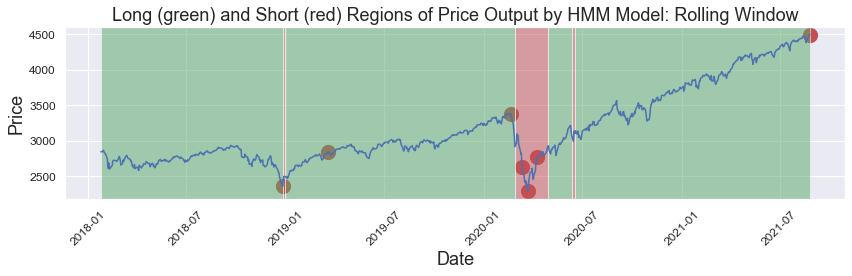

In [941]:
split = 0.76

model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
model, start_idx, split_val = multi_train_com(data_re, split, window, 22)
s, start = multi_test_com(model, start_idx, stock_to_validate, window, delay, seed)


validate(stock_to_validate, s, start)
trial_price = ret_data(stock_to_validate)["Open"].loc[start:][1:]
plot_highlighted_graph(trial_price, threshold, s, "Real Estate to Predict S&P500")

## Industrials Results

35 324
Strategy:
Sharpe | Sortino | Calmar Ratios
2.239 2.873 0.225
Asset:
Sharpe | Sortino | Calmar Ratios
2.239 2.869 0.225


Strategy Annualised Return:
0.423
Asset Annualised Return:
0.423
Strategy Annualised Vol:
0.152
Asset Annualised Vol:
0.151


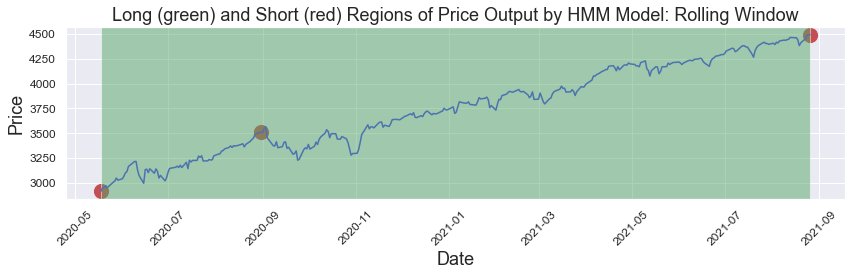

In [942]:
split = 0.1

model, start_idx, split_val = multi_train_com(data_i, split, window, 22)
s, start = multi_test_com(model, start_idx, stock_to_validate, window, delay, seed)
validate(stock_to_validate, s, start)
trial_price = ret_data(stock_to_validate)["Open"].loc[start:][1:]
plot_highlighted_graph(trial_price, threshold, s, "Industrials to Predict S&P500")

## Consumer Discretionary Results

449 913
Strategy:
Sharpe | Sortino | Calmar Ratios
1.145 1.384 0.056
Asset:
Sharpe | Sortino | Calmar Ratios
0.763 0.882 0.026


Strategy Annualised Return:
0.226
Asset Annualised Return:
0.172
Strategy Annualised Vol:
0.144
Asset Annualised Vol:
0.175


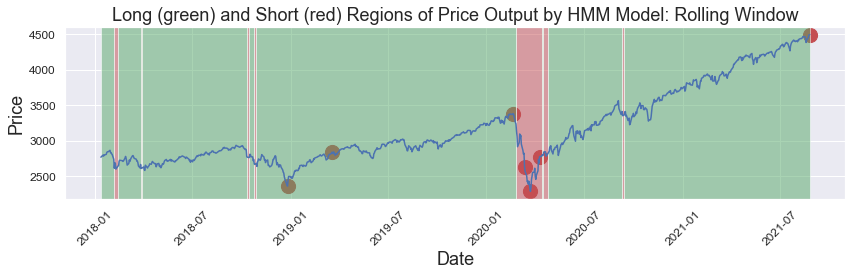

In [943]:
split = 0.33

model, start_idx, split_val = multi_train_com(data_cd, split, window, 22)
s, start = multi_test_com(model, start_idx, stock_to_validate, window, delay, seed)
validate(stock_to_validate, s, start)
trial_price = ret_data(stock_to_validate)["Open"].loc[start:][1:]
plot_highlighted_graph(trial_price, threshold, s, "Consumer Discretionary to Predict S&P500")

### Obtaining Results and Cross Validating on Different Stocks

In [916]:
# way to get location of numerical value of datetime idx
ret_data(stock_to_validate)["Close"].index.get_loc(start_idx)

2545

1443 886
Strategy:
Sharpe | Sortino | Calmar Ratios
0.97 1.152 0.045
Asset:
Sharpe | Sortino | Calmar Ratios
0.833 0.972 0.028


Strategy Annualised Return:
0.18
Asset Annualised Return:
0.187
Strategy Annualised Vol:
0.144
Asset Annualised Vol:
0.173


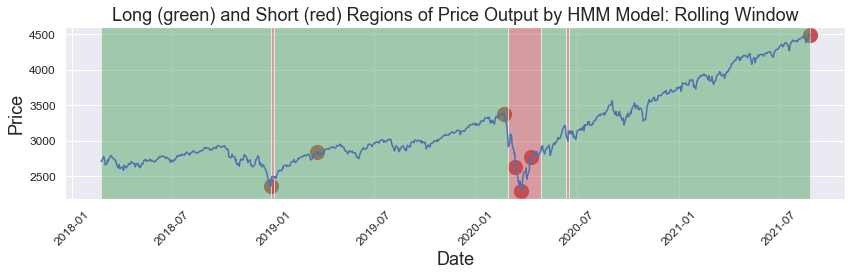

In [946]:
from datetime import datetime, timedelta
split = 0.62
window = 1004
delay = 2
seed = 22
stock_to_validate = "^GSPC"
ticks = ["AAPL", "MSFT", "GOOG", "AMZN", "FB", "NFLX"]

data = create_input_df(ticks)
model, start_idx, split_val = multi_train_com(data, split, window, 22)
s, start = multi_test_com(model, start_idx, stock_to_validate, window, delay, seed)
validate(stock_to_validate, s, start)
trial_price = ret_data(stock_to_validate)["Open"].loc[start:][1:]
plot_highlighted_graph(trial_price, threshold, s, "Multi-Training - S&P500")

## Training with entire sectors

2006-09-05 00:00:00
Strategy:
Sharpe | Sortino | Calmar Ratios
0.932 1.068 0.049
Asset:
Sharpe | Sortino | Calmar Ratios
0.813 0.931 0.029


Strategy Annualised Return:
0.166
Asset Annualised Return:
0.183
Strategy Annualised Vol:
0.145
Asset Annualised Vol:
0.18


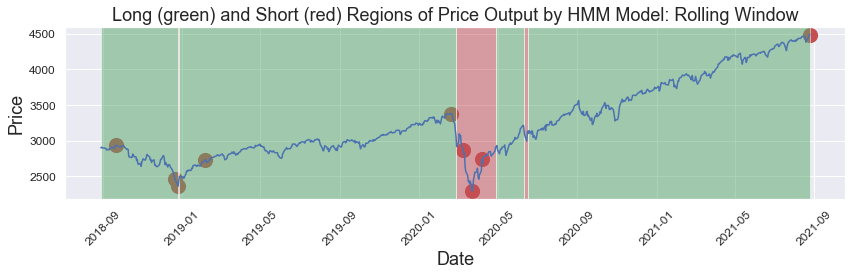

In [847]:
split = 0.8
window = 1004
delay = 1
seed = 22
stock_to_validate = "^GSPC"
#df = pd.read_csv("real-estate.csv")
#ticks = list(df["Symbol"][0:-1].values)


#data = create_input_df(ticks)


model, start_idx, split_val = multi_train_com(data, split, window, 22)
s, start = multi_test_com(model, start_idx, stock_to_validate, window, delay, seed)
validate(stock_to_validate, s, start)
trial_price = ret_data(stock_to_validate)["Open"].loc[start:][1:]
plot_highlighted_graph(trial_price, threshold, s, "Multi-Training - S&P500")

In [ ]:
stock_to_validate = "GSPC^"

Strategy:
Sharpe | Sortino | Calmar Ratios
1.264 1.43 0.073
Asset:
Sharpe | Sortino | Calmar Ratios
0.51 0.671 0.04


Strategy Annualised Return:
0.623
Asset Annualised Return:
0.307
Strategy Annualised Vol:
0.329
Asset Annualised Vol:
0.478


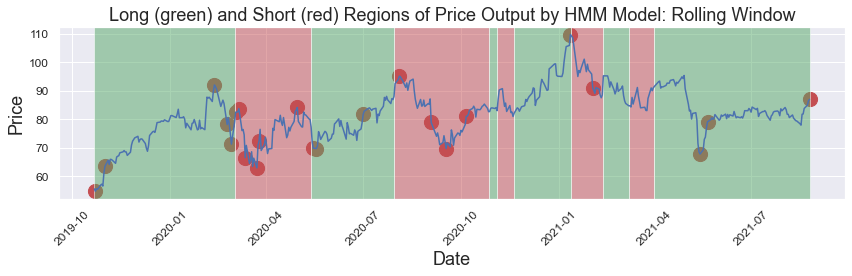

In [760]:
split = 0.8
window = 1004
delay = 5
seed = 22
stock_to_validate = "LITE"
ticks = ["AAPL", "MSFT", "GOOG", "AMZN", "FB"]

data = create_input_df(ticks)
s, start_idx = multi_train(data, split, window, delay, 22)
validate(stock_to_validate, s, start_idx)
trial_price = ret_data(stock_to_validate)["Open"].loc[start_idx:][1:]
plot_highlighted_graph(trial_price, threshold, s, "Multi-Training - S&P500")

In [729]:
data

AAPL      MSFT      GOOG      AMZN        FB
Date                                                        
2012-05-25  -0.00536 -0.000344 -0.020094 -0.010918 -0.033909
2012-05-29  0.017749  0.017206   0.00475  0.008737 -0.096208
2012-05-30  0.012058 -0.007443  -0.01028 -0.025704 -0.022538
2012-05-31 -0.002486 -0.005112 -0.012529  0.017588  0.050018
2012-06-01 -0.028975 -0.025351 -0.017009 -0.022028 -0.063514
...              ...       ...       ...       ...       ...
2021-08-19  0.002323  0.020775  0.002515 -0.004208 -0.000928
2021-08-20  0.010157  0.025575  0.011127  0.003827  0.011968
2021-08-23  0.010257  0.000953  0.019233    0.0206  0.011075
2021-08-24 -0.000601 -0.006663  0.009206   0.01222  0.005945
2021-08-25 -0.008421 -0.002016  0.003873 -0.001997  0.007879

[2328 rows x 5 columns]

### Cross Validating Different Windows Sizes

In [602]:
# this function takes a dataframe of input features OR a single numpy array - to train a model and outputs the trained model 
def model_fit(data, split, seed, df):
    # initialising seed and counter
    np.random.seed(seed)
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    
    # obtaining splits of data
    split_val = int(split*len(data))
    
    if df == True:
        train = data[:split_val]

        # create the input numpy array from the pd df
        data_list = [train.iloc[:, i].values for i in range(len(train.columns))]
        X = np.concatenate(data_list)
        X = X.reshape(-1,1)
        lengths = [len(train.iloc[:, i].values) for i in range(len(train.columns))]
        
        model = model.fit(X, lengths)
        
        return model
        
    else:
        X = data[:split_val]
        X = X.reshape(-1,1)
        model = model.fit(X)
        
        return model

    
    

# this function takes in one asset that you want to predict and predict it using an input model
def model_predict(model, start, end, X_to_pred, split, window, delay, seed):
    # reshape the signal to be predicted
    X = X_to_pred.reshape(-1,1)
    count = 0
    
    # predict with the model
    signal = []
    predictions = model.predict(X[start-window:start])
    signal.append(predictions[-1])
    prev_pred = predictions[-1]

    for i in range(1, end-start):
        predictions = model.predict(X[start-window+i:start+i])
        pred = predictions[-1]

        if pred == prev_pred:
            count = count + 1 

        elif pred != prev_pred:
            count = 1

        if count >= delay:
            signal.append(pred)

        elif count < delay:
            signal.append(signal[-1])

        prev_pred = pred

    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)

    else: 
        signal = np.array(signal)

    return signal

### Plotting the Various Crashes

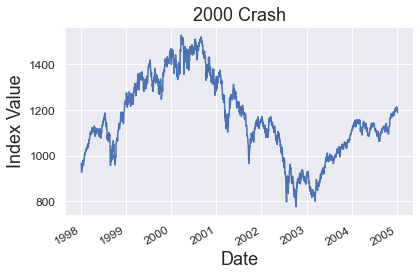

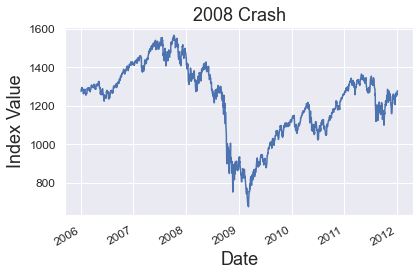

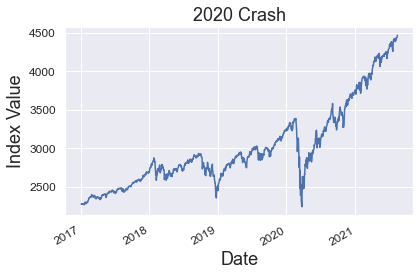

In [724]:
# stock.index.get_loc('2013-01-02 00:00:00')

ticker = yf.Ticker('^GSPC')
stock = ticker.history(period="30y")

crash_1_idx = [1617, 3377]
plt.title("2000 Crash", fontsize=18)
plt.ylabel("Index Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
stock["Close"][crash_1_idx[0]:crash_1_idx[1]].plot()
plt.tight_layout()
plt.savefig("2000 Crash")
plt.show()


crash_2_idx = [3629, 5140]
plt.title("2008 Crash", fontsize=18)
plt.ylabel("Index Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
stock["Close"][crash_2_idx[0]:crash_2_idx[1]].plot()
plt.tight_layout()
plt.savefig("2008 Crash")
plt.show()


crash_3_idx = [6398, len(stock)]
plt.title("2020 Crash", fontsize=18)
plt.ylabel("Index Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
stock["Close"][crash_3_idx[0]:crash_3_idx[1]].plot()
plt.tight_layout()
plt.savefig("2020 Crash")
plt.show()


## Cross Validating Different Window Sizes Across Different Crashes

In [570]:
crash_idxs = [[1617, 3377], [3629, 5140], [6398, len(stock)]]
crash_idxs[2][0]/crash_idxs[2][1]

0.8470806302131604

### Cross validating window size using the train-test split fit method 

In [725]:
# importing the data
ticker = yf.Ticker('^GSPC')
stock = ticker.history(period="30y")
stock["Returns"] = stock["Close"].pct_change().dropna()
stock["Log Returns"] = np.log(1 + stock["Returns"])
stock = stock.dropna()
stock["Vol"] = stock["Returns"].rolling(5).std()
stock = stock.dropna()

windows = [750, 1000, 1250]
crash_idxs = [[1617, 3377], [3629, 5140], [6398, len(stock)]]

delay = 5
states = 2
threshold = 0.15
seed = 22

for j in range(0, len(windows)):
    for k in range(3):
        print("Window: ", j)
        print("Crash: ", k)
        print("\n")
        start = crash_idxs[k][0]
        end = crash_idxs[k][1]
        window = windows[j]
        price = stock[start+1:end]["Open"]
        X = stock["Log Returns"].values
        
        split = crash_idxs[k][0]/crash_idxs[k][1]
        model = model_fit(X[:end], split, seed, False)
        signal = model_predict(model, start, end, X, split, window, delay, seed)
    
        
        strat = backtest_signal(price, signal)
        print_ratios(strat, price)
        print_ann_ret(strat, price)
        #plot_highlighted_graph(price, threshold, signal, "S&P w delay (5) ret+vol Rolling window base result performance")
        print("\n\n")
        
        

Window:  0
Crash:  0


Strategy:
Sharpe | Sortino | Calmar Ratios
0.124 0.182 0.003
Asset:
Sharpe | Sortino | Calmar Ratios
0.161 0.241 0.004


Strategy Annualised Return:
0.025
Asset Annualised Return:
0.036
Strategy Annualised Vol:
0.189
Asset Annualised Vol:
0.199



Window:  0
Crash:  1


Strategy:
Sharpe | Sortino | Calmar Ratios
0.004 0.004 0.0
Asset:
Sharpe | Sortino | Calmar Ratios
0.003 0.004 0.0


Strategy Annualised Return:
0.001
Asset Annualised Return:
0.001
Strategy Annualised Vol:
0.216
Asset Annualised Vol:
0.234



Window:  0
Crash:  2


Strategy:
Sharpe | Sortino | Calmar Ratios
1.061 0.99 0.048
Asset:
Sharpe | Sortino | Calmar Ratios
0.934 1.037 0.029


Strategy Annualised Return:
0.135
Asset Annualised Return:
0.211
Strategy Annualised Vol:
0.099
Asset Annualised Vol:
0.158



Window:  1
Crash:  0


Strategy:
Sharpe | Sortino | Calmar Ratios
0.124 0.182 0.003
Asset:
Sharpe | Sortino | Calmar Ratios
0.161 0.241 0.004


Strategy Annualised Return:
0.025
Asset Annualis

### Cross validating window size using the rolling fit method 

In [727]:
# importing the data
ticker = yf.Ticker('^GSPC')
stock = ticker.history(period="30y")
stock["Returns"] = stock["Close"].pct_change().dropna()
stock = stock.dropna()
stock["Vol"] = stock["Returns"].rolling(5).std()
stock = stock.dropna()

windows = [752, 1000, 1250]
crash_idxs = [[1617, 3377], [3629, 5140], [6398, len(stock)]]

delay = 5
states = 2
threshold = 0.15

for j in range(0, len(windows)):
    for k in range(3):
        print("Window: ", j)
        print("Crash: ", k)
        print("\n")
        start = crash_idxs[k][0]
        end = crash_idxs[k][1]
        window = windows[j]
        price = stock[start+1:end]["Open"]
        X = log_returns(stock["Close"].values)
        
        signal = generate_signal_rolling(start, end, X, states, window, delay, 22)
        strat = backtest_signal(price, signal)
        print_ratios(strat, price)
        print_ann_ret(strat, price)
        #plot_highlighted_graph(price, threshold, signal, "S&P w delay (5) ret+vol Rolling window base result performance")
        print("\n\n")

Window:  0
Crash:  0


Strategy:
Sharpe | Sortino | Calmar Ratios
0.006 0.009 0.0
Asset:
Sharpe | Sortino | Calmar Ratios
0.161 0.241 0.004


Strategy Annualised Return:
0.001
Asset Annualised Return:
0.036
Strategy Annualised Vol:
0.183
Asset Annualised Vol:
0.199



Window:  0
Crash:  1


Strategy:
Sharpe | Sortino | Calmar Ratios
0.011 0.013 0.0
Asset:
Sharpe | Sortino | Calmar Ratios
0.003 0.004 0.0


Strategy Annualised Return:
0.003
Asset Annualised Return:
0.001
Strategy Annualised Vol:
0.234
Asset Annualised Vol:
0.234



Window:  0
Crash:  2


Strategy:
Sharpe | Sortino | Calmar Ratios
1.152 1.175 0.058
Asset:
Sharpe | Sortino | Calmar Ratios
0.934 1.037 0.029


Strategy Annualised Return:
0.181
Asset Annualised Return:
0.211
Strategy Annualised Vol:
0.114
Asset Annualised Vol:
0.158



Window:  1
Crash:  0


Strategy:
Sharpe | Sortino | Calmar Ratios
-0.057 -0.081 -0.001
Asset:
Sharpe | Sortino | Calmar Ratios
0.161 0.241 0.004


Strategy Annualised Return:
-0.01
Asset Annual

## Results for Rolling Window Back-Test
- 2 states
- 4 year rolling window
- 7 day delay

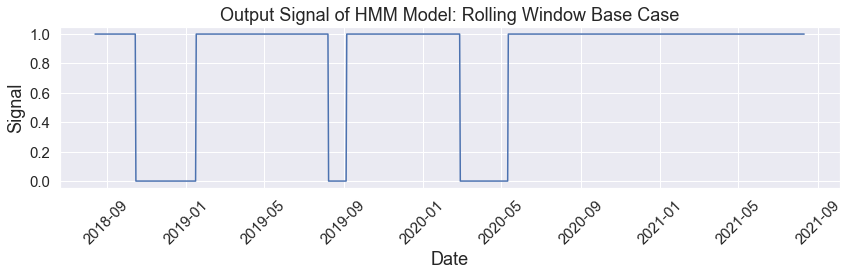

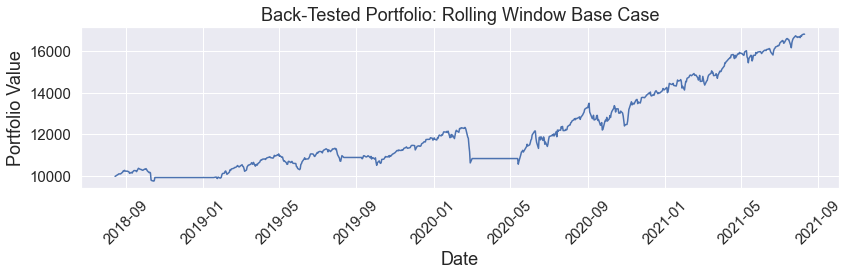

Strategy:
Sharpe | Sortino | Calmar Ratios
1.352 1.45 0.077
Asset:
Sharpe | Sortino | Calmar Ratios
0.842 0.96 0.03


Strategy Annualised Return:
0.228
Asset Annualised Return:
0.191


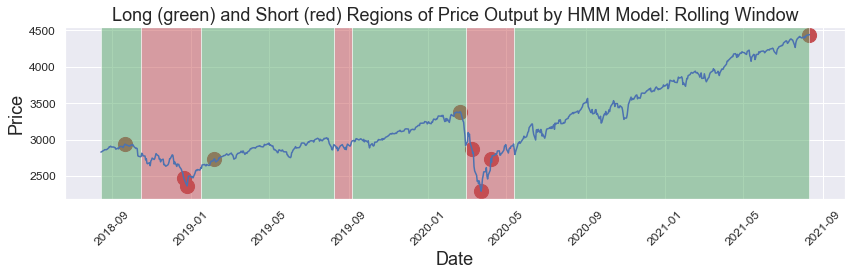

In [553]:
sns.set()

# importing the data
ticker = yf.Ticker('^GSPC')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change().dropna()
msft = msft.dropna()
msft["Vol"] = msft["Returns"].rolling(5).std()
msft = msft.dropna()

# initialising function parameters
start = 3017
end = len(msft)
X = log_returns(msft["Close"].values)


window = 500
delay = 5
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# calling function
signal = generate_signal_rolling(start, end, X, states, window, delay, 22)

# plotting signal 
idx = msft.index[start:]
plt.figure(figsize=(12,4))
plt.title("Output Signal of HMM Model: Rolling Window Base Case", fontsize=18)
plt.ylabel("Signal", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx, signal)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("S&P w delay (5) ret+vol Rolling Window signal base result")
plt.show()

# back-testing signal
strat = backtest_signal(price, signal)

# plotting back-tested portfolio
plt.figure(figsize=(12,4))
plt.title("Back-Tested Portfolio: Rolling Window Base Case", fontsize=18)
plt.ylabel("Portfolio Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx[1:-1], strat)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("S&P w delay (5) ret+vol Rolling Window portfolio backtest base result")
plt.show()

# printing performance ratios
print_ratios(strat, price)

# print annualised returns
print_ann_ret(strat, price)

# plotting long and short graph
plot_highlighted_graph(price, threshold, signal, "S&P w delay (5) ret+vol Rolling window base result performance")

### Downsampling Data to 1 Week and Obtaining Results

- You need to create modified ratios to accomodate for the fact the data is weekly - can't annualise using 252 anymore: 52
- Modify all performance metrics matter of fact: ratios, annual return etc. 

In [181]:
def weekly_sharpe(returns):
    sharpe_ratio = np.mean(returns)/np.std(returns)
    return np.round(sharpe_ratio * np.sqrt(52), 3)

def weekly_sortino(returns):
    downside_returns = [ret for ret in returns if ret < 0]
    std = np.std(downside_returns)
    sortino = np.mean(returns)/std
    return np.round(sortino * np.sqrt(52), 3)

def weekly_max_dd(data):
    p = np.argmax(np.maximum.accumulate(data) - data)
    q = np.argmax(data[:p])
    max_drawdown = (data[p]-data[q])/data[q]
    return np.round(abs(max_drawdown), 3)

def weekly_calmar(returns, strat):
    drawdown = max_dd(strat)
    calmar = np.sqrt(252) * np.mean(returns)/drawdown
    return np.round(calmar, 3) 

def weekly_absolute_return(price):
    abs_ret = (price[-1] - price[0])/price[0]
    annual_abs_ret = abs_ret/(len(price)/52)
    return annual_abs_ret

def weekly_print_ann_ret(strat, price):
    print("Strategy Annualised Return:", round(weekly_absolute_return(strat),3), sep='\n')
    print("Asset Annualised Return:", round(weekly_absolute_return(price.values),3), sep='\n')

def weekly_print_ratios(strategy, price):
    print("Strategy:\nSharpe | Sortino | Calmar Ratios")
    print(
    weekly_sharpe(log_returns(strat)),
    weekly_sortino(log_returns(strat)),
    weekly_calmar(log_returns(strat), strat))
    print("Asset:\nSharpe | Sortino | Calmar Ratios")
    print(
    weekly_sharpe(log_returns(price.values)),
    weekly_sortino(log_returns(price.values)),
    weekly_calmar(log_returns(price.values), price.values))
    print("\n")

Strategy:
Sharpe | Sortino | Calmar Ratios
0.344 0.332 0.036
Asset:
Sharpe | Sortino | Calmar Ratios
0.771 0.756 0.162


Strategy Annualised Return:
0.121
Asset Annualised Return:
0.186
DatetimeIndex(['2018-08-19', '2018-08-26', '2018-09-02', '2018-09-09',
               '2018-09-16', '2018-09-23', '2018-09-30', '2018-10-07',
               '2018-10-14', '2018-10-21',
               ...
               '2021-06-13', '2021-06-20', '2021-06-27', '2021-07-04',
               '2021-07-11', '2021-07-18', '2021-07-25', '2021-08-01',
               '2021-08-08', '2021-08-15'],
              dtype='datetime64[ns]', name='Date', length=157, freq='W-SUN')


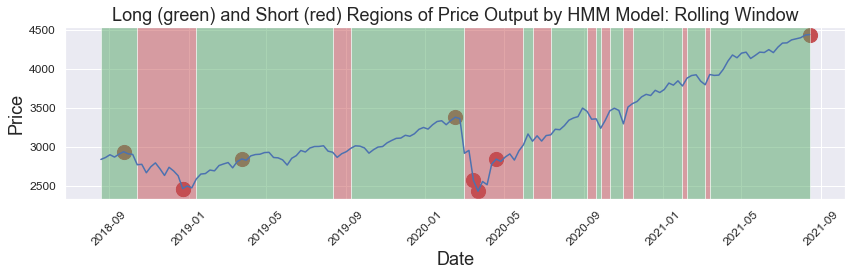

In [426]:
for_samp = pd.DataFrame([price.values, signal, price.index]).T
for_samp = for_samp[:-1]
for_samp.columns = ["Price", "Signal", "Date"]
for_samp = for_samp.set_index("Date")
weekly_price = for_samp["Price"].resample('W').last()
weekly_price = pd.to_numeric(weekly_price)
weekly_signal = for_samp["Signal"].resample('W').last()

weekly_strat = backtest_signal(weekly_price, weekly_signal)
weekly_print_ratios(weekly_strat, weekly_price)
weekly_print_ann_ret(weekly_strat, weekly_price)

plot_highlighted_graph(weekly_price, threshold, weekly_signal, "S&P weekly w delay (5) ret+vol Rolling window base result performance")

In [405]:
print(len(weekly_signal), len(weekly_price))
print(len(signal), len(price))

157 157
753 752


## Results for Expanding Window Back-Test (same Paramters)

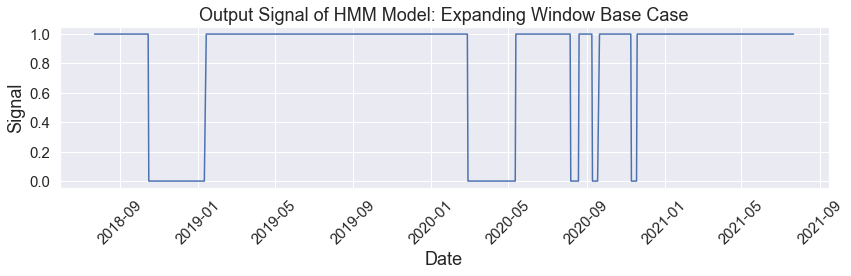

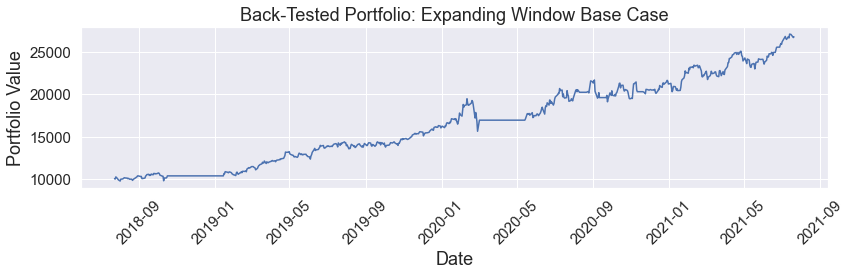

Strategy:
Sharpe | Sortino | Calmar Ratios
1.49 1.811 0.105
Asset:
Sharpe | Sortino | Calmar Ratios
1.197 1.57 0.075


Strategy Annualised Return:
0.563
Asset Annualised Return:
0.573


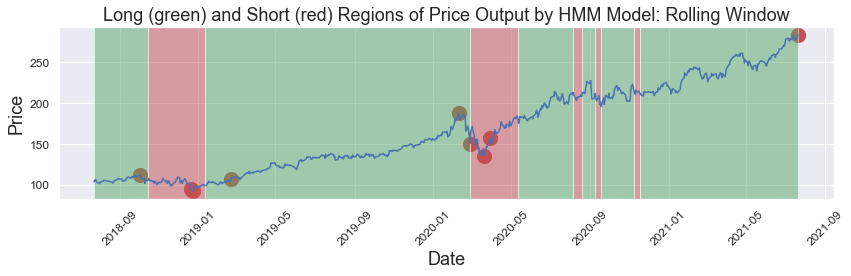

In [53]:
# importing the data
ticker = yf.Ticker('MSFT')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change()
msft = msft.dropna()

# initialising function parameters
start = len(msft) - 756
end = len(msft)
X = log_returns(msft["Close"].values)
delay = 5
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# calling function
signal = generate_signal_expanding(start, end, X, states, delay, 2200)

# plotting signal 
idx = msft.index[start:]
plt.figure(figsize=(12,4))
plt.title("Output Signal of HMM Model: Expanding Window Base Case", fontsize=18)
plt.ylabel("Signal", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx, signal)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Expanding Window signal base result")
plt.show()

# back-testing signal
strat = backtest_signal(price, signal)

# plotting back-tested portfolio
plt.figure(figsize=(12,4))
plt.title("Back-Tested Portfolio: Expanding Window Base Case", fontsize=18)
plt.ylabel("Portfolio Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx[1:-1], strat)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Expanding Window portfolio backtest base result")
plt.show()

# printing performance ratios
print_ratios(strat, price)

# print annualised returns
print_ann_ret(strat, price)

# plotting long and short graph
plot_highlighted_graph(price, threshold, "expanding window base result performance")

In [612]:
from scipy.stats import norm

def ret_df(signal, returns):
    df = pd.DataFrame()
    df["Returns"] = returns
    df["Signal"] = signal
    return df

def ret_norm_params(var):
    params = norm.fit(var)
    mean = params[0]
    std_dev = params[1]
    return mean, std_dev

def switch_signal(signal):
    signal = list(signal)
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        return signal
    else: 
        signal = np.array(signal)
        return signal
    
def normal_dist(x, mu, std):
    p = (1/np.sqrt(2*np.pi*std**2)) * np.exp(-((x-mu)**2)/2*std**2)
    return p

In [647]:
def generate_signal_expanding_w_NBC(start, end, X, states, delay, seed):
    np.random.seed(seed)
    signal = []
    count = 0
    NBC_count = 0
    NBC_preds = []
    X_reshape = X.reshape(-1, 1)
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    model.fit(X_reshape[:start])
    predictions = model.predict(X_reshape[:start])
    
    p = NBC(predictions, X[:start])
    NBC_preds.append((p, predictions[-1]))
    
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    for i in range(1, end-start):
        model.fit(X_reshape[:start+i])
        predictions = model.predict(X_reshape[:start+i])
        pred = predictions[-1]
        
        p = NBC(predictions, X[:start+i])
        NBC_preds.append((p, pred))
        
        if pred == np.argmax(ncp[i][0]):
            signal.append(pred)
            
        else:
            signal.append(np.argmax(ncp[i][0]))
            NBC_count = NBC_count + 1

        
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        
    else: 
        signal = np.array(signal)
        
        
    return signal, NBC_count, NBC_preds

def NBC(predictions, X):
    # making sure more 1's than 0's
    predictions = switch_signal(predictions)
    predictions = predictions
    
    # calculating probability of either regime historically
    p_C0 = list(predictions).count(0)/len(predictions)
    p_C1 = list(predictions).count(1)/len(predictions)
    
    # returning df with returns and the signal
    df = ret_df(predictions, X)
    
    # obtaining returns from both states
    returns_0_state = df[df["Signal"] == 0]["Returns"]
    returns_1_state = df[df["Signal"] == 1]["Returns"]
    
    # fitting returns from both states to obtain parameters
    mean_0, std_0 = ret_norm_params(returns_0_state)
    mean_1, std_1 = ret_norm_params(returns_1_state)
    
    # fitting most recent return value to both distributions
    x = X[-1]
    px_C0 = normal_dist(x, mean_0, std_0)
    px_C1 = normal_dist(x, mean_1, std_1)
    
    # using norm pdf instead of manually creating norm dist
    px_C0 = norm.pdf(x, mean_0, std_0)
    px_C1 = norm.pdf(x, mean_1, std_1)
    
    
    # calculating the probability of the data
    px = px_C0*p_C0 + px_C1*p_C1
    
    # final output
    pC0_x = (p_C0*px_C0)/px
    pC1_x = (p_C1*px_C1)/px

    #probabilities = [px_C0, px_C1]
    probabilities = [pC0_x, pC1_x]
    
    return probabilities

In [648]:
# importing the data
ticker = yf.Ticker('MSFT')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change()
msft = msft.dropna()

# initialising function parameters
start = len(msft) - 756
end = len(msft)
X = log_returns(msft["Close"].values)
delay = 5
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# calling function
signal, nc, ncp = generate_signal_expanding_w_NBC(start, end, X, states, delay, 2200)

In [650]:
ncp

[([0.04324012563614274, 0.9567598743638572], 1),
 ([0.045619182164245875, 0.9543808178357541], 1),
 ([0.0557832633116107, 0.9442167366883893], 1),
 ([0.07106613869111204, 0.928933861308888], 1),
 ([0.037137552193368895, 0.9628624478066311], 1),
 ([0.03812120693224413, 0.9618787930677559], 1),
 ([0.04513194743666289, 0.9548680525633371], 1),
 ([0.049367180975486626, 0.9506328190245134], 1),
 ([0.04928390395216188, 0.9507160960478381], 1),
 ([0.03949942842183221, 0.9605005715781677], 1),
 ([0.04430091442456317, 0.9556990855754369], 1),
 ([0.0525123297576775, 0.9474876702423225], 1),
 ([0.04140072992917779, 0.9585992700708221], 1),
 ([0.07587792304648384, 0.9241220769535161], 1),
 ([0.038377279685751636, 0.9616227203142483], 1),
 ([0.038839295741835166, 0.9611607042581648], 1),
 ([0.04330215619058633, 0.9566978438094137], 1),
 ([0.4312907536065294, 0.5687092463934706], 1),
 ([0.03831391006646501, 0.961686089933535], 1),
 ([0.04220199730190564, 0.9577980026980943], 1),
 ([0.051540989019159

In [651]:
# back-testing signal
strat = backtest_signal(price, signal)
# printing performance ratios
print_ratios(strat, price)
# print annualised returns
print_ann_ret(strat, price)

Strategy:
Sharpe | Sortino | Calmar Ratios
1.009 1.113 0.058
Asset:
Sharpe | Sortino | Calmar Ratios
1.209 1.578 0.076


Strategy Annualised Return:
0.324
Asset Annualised Return:
0.578


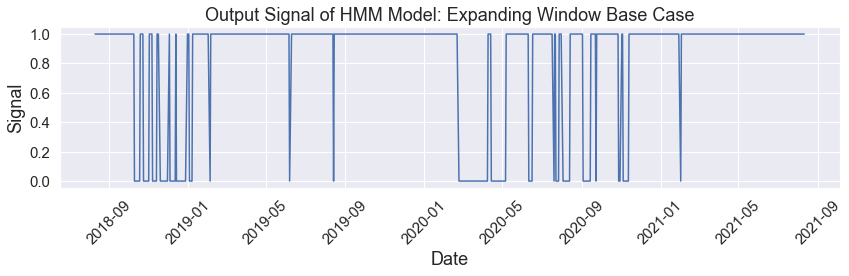

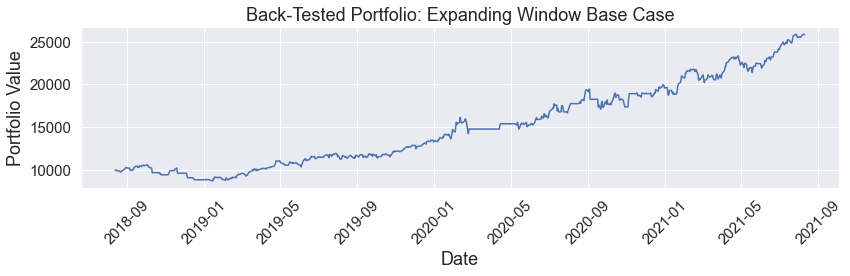

Strategy:
Sharpe | Sortino | Calmar Ratios
1.472 1.741 0.164
Asset:
Sharpe | Sortino | Calmar Ratios
1.209 1.578 0.076


Strategy Annualised Return:
0.528
Asset Annualised Return:
0.578


TypeError: plot_highlighted_graph() missing 1 required positional argument: 'string'

In [618]:
# importing the data
ticker = yf.Ticker('MSFT')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change()
msft = msft.dropna()

# initialising function parameters
start = len(msft) - 756
end = len(msft)
X = log_returns(msft["Close"].values)
delay = 5
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# calling function
signal, nc, ncp = generate_signal_expanding_w_NBC(start, end, X, states, delay, 2200)


# plotting signal 
idx = msft.index[start:]
plt.figure(figsize=(12,4))
plt.title("Output Signal of HMM Model: Expanding Window Base Case", fontsize=18)
plt.ylabel("Signal", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx, signal)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# back-testing signal
strat = backtest_signal(price, signal)

# plotting back-tested portfolio
plt.figure(figsize=(12,4))
plt.title("Back-Tested Portfolio: Expanding Window Base Case", fontsize=18)
plt.ylabel("Portfolio Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx[1:-1], strat)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# printing performance ratios
print_ratios(strat, price)

# print annualised returns
print_ann_ret(strat, price)

# plotting long and short graph
plot_highlighted_graph(price, threshold, signal, "expanding window base result performance")

In [623]:
ncp

[([0.03709062851189892, 0.9629093714881011], 1),
 ([0.03707374324914035, 0.9629262567508596], 1),
 ([0.03706027962356941, 0.9629397203764306], 1),
 ([0.03705024489629679, 0.9629497551037033], 1),
 ([0.0370303746135057, 0.9629696253864942], 1),
 ([0.037898540860250525, 0.9621014591397495], 1),
 ([0.03788080942737005, 0.96211919057263], 1),
 ([0.03786448767994302, 0.9621355123200569], 1),
 ([0.037848441715668986, 0.9621515582843311], 1),
 ([0.03782886212942245, 0.9621711378705776], 1),
 ([0.03819322875677931, 0.9618067712432207], 1),
 ([0.038177921043389164, 0.9618220789566108], 1),
 ([0.03815879326973752, 0.9618412067302625], 1),
 ([0.03814953036935615, 0.9618504696306438], 1),
 ([0.0381291613595711, 0.961870838640429], 1),
 ([0.038109055809074366, 0.9618909441909257], 1),
 ([0.03809056088839671, 0.9619094391116033], 1),
 ([0.038114268641503905, 0.9618857313584961], 1),
 ([0.03809398986254285, 0.9619060101374571], 1),
 ([0.038075134150701545, 0.9619248658492985], 1),
 ([0.03805967009671